In [34]:
import  face_recognition as fr
import numpy as np
import pandas as pd
from glob import glob

import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [27]:
image_files = glob('images/*')

In [28]:
def extract_face_encodings(image_file):
    image = fr.load_image_file(image_file)
    return fr.face_encodings(image)[0]

In [43]:
image = cv2.imread(image_file)
image_p = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
face_locations = fr.face_locations(image, number_of_times_to_upsample=2, model="cnn")
face_encodings = fr.face_encodings(image_p, face_locations)
face_locations

[]

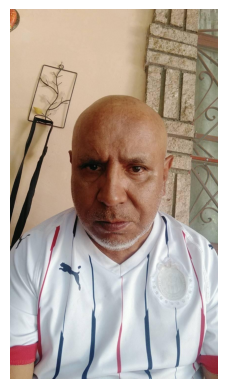

In [45]:
# Plot the image using matplotlib
plt.imshow(image_p)
plt.axis('off')  # Turn off axis labels
plt.show()

In [31]:
extract_face_encodings(image_file)

IndexError: list index out of range

In [29]:
image_dataset = []
for image_file in tqdm(image_files):
    face_enc = extract_face_encodings(image_file)
    image_dataset.append([image_file, face_enc])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:09<49:54,  3.00s/it]


IndexError: list index out of range

In [22]:
image2 = fr.load_image_file(file_images[0])
face_landmarks = fr.face_encodings(image2)[0]

In [ ]:
query = 'SELECT id_user, name, last_name, face_id_1, face_id_2 from profiles'
df_face_encodings  = self.obj_db.consult(query,modification=False)
df_face_encodings  = pd.DataFrame(data = df_face_encodings , columns= ["id_user", "name", "last_name", "face_id_1", "face_id_2"])
face_id_cols = [x for x in df_face_encodings.columns if 'face_id' in x.lower()]
for col in face_id_cols:
    df_face_encodings[col] = df_face_encodings[col].apply( self.obj_db.blob2array )

df_face_encodings = pd.melt(df_face_encodings, id_vars = ['id_user','name','last_name'], value_vars = face_id_cols, var_name='Face_id', value_name='Encoding')
df_face_encodings = df_face_encodings[df_face_encodings['Encoding'].map(len) == 128]

known_face_encodings = np.vstack(df_face_encodings['Encoding'])

matches = fr.compare_faces(known_face_encodings, self.FaceCode, 0.4)
print ("MATCHES COMPARED: {}".format (matches))
if True in matches:
    print('User detected')
    user = df_face_encodings[matches]
    self.__user_id  = user['id_user'].values[0]
    self.__user_name= user['name'].values[0]
    print('Bienvenido {} {} !'.format(user['name'].values[0] , user['id_user'].values[0] ))

    if not self.__plan_check() :
        self.__last_desition(res = False)
        return False

    if self.__matrType > 0 :
        if not self.__matr_check() :
            self.__last_desition(res = False)
            return False

    return True
else:
    return False
return